## Runs DE on different clusters. Also runs DE within each cluster for each condition

In [1]:
#integrated_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/mergedSamples/allSamples.integrated.rds" 
clones_indir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF"
sample_names = "preB,postB"
cores = 8

genome = "/data/Mito_Trace/data/external/GRCh38_MT_blacklist/fasta/genome.fa"
comps_f = ""
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"
#cond.comparisons <- "A,preA,postA;B,preB,postB"

In [2]:
source(utils_script)

Attaching SeuratObject



## Libraries

In [3]:
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)



Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: GenomicRanges

Loading required package: Biostrings

Loadin

In [4]:
library(dplyr)

library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: Annot

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
#clust_outdir = file.path(outdir, "clusters")
#clust_atac_outdir = file.path(outdir, "clusters_atac")
cond_outdir = file.path(outdir, "conditions_clusters")
#cons_outdir = file.path(outdir, "conditions_conserved")
dir.create(outdir, showWarnings = T)
#dir.create(clust_outdir, showWarnings = FALSE)
dir.create(cond_outdir, showWarnings = T)
#dir.create(cons_outdir, showWarnings = FALSE)
#dir.create(clust_atac_outdir, showWarnings = FALSE)

Warning message in dir.create(outdir, showWarnings = T):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF' already exists"
Warning message in dir.create(cond_outdir, showWarnings = T):
"'/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/DE_TF/conditions_clusters' already exists"


In [6]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
#samples <- unlist(strsplit(samples, ","))

sample_names

[1] "preB"  "postB"

In [7]:
# # extract gene annotations from EnsDb
# annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# # change to UCSC style since the data was mapped to hg19
# seqlevelsStyle(annotations) <- 'UCSC'
# genome(annotations) <- "hg38"

# # add the gene information to the object
# Annotation(integrated) <- annotations


# gene.activities <- GeneActivity(integrated)


In [8]:
se <- readRDS(file.path(clones_indir, "SE.rds"))
se$donor.cond = paste0("d", se$donor, se$condition)
se

# integrated <- readRDS(integrated_f)#file.path(indir, paste0("allSamples.integrated.rds")))
# integrated

An object of class Seurat 
62328 features across 3683 samples within 2 assays 
Active assay: RNA (20010 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [9]:
se[[]]

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,⋯,ATAC_snn_res.0.8,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<dbl>,<int>,<chr>,<I<chr>>,<fct>,<fct>,<fct>,<fct>
preB_AAACGAAGTCACTCTC-1,preB,3754,3754,38954,29912,335,145,1057,0,7505,⋯,0,0,3751,2539,AAACGAAGTCACTCTC-1_preB,preB_AAACGAAGTCACTCTC-1,10,0,preB,0_10
preB_AAACGAAGTCCCTAAA-1,preB,4130,4130,24309,15056,258,113,968,0,7914,⋯,6,6,4280,2832,AAACGAAGTCCCTAAA-1_preB,preB_AAACGAAGTCCCTAAA-1,33,3,preB,3_33
preB_AAACGAAGTCTGTGTA-1,preB,683,683,17674,15525,189,72,200,0,1688,⋯,2,2,581,517,AAACGAAGTCTGTGTA-1_preB,preB_AAACGAAGTCTGTGTA-1,20,1,preB,1_20
preB_AAACTCGCAACTCGTA-1,preB,5270,5270,39016,26386,437,223,1941,0,10029,⋯,6,6,5460,3063,AAACTCGCAACTCGTA-1_preB,preB_AAACTCGCAACTCGTA-1,0,2,preB,2_0
preB_AAACTCGCAGAACGAC-1,preB,5575,5575,70990,51473,759,331,2599,0,15828,⋯,5,5,8266,3971,AAACTCGCAGAACGAC-1_preB,preB_AAACTCGCAGAACGAC-1,9,2,preB,2_9
preB_AAACTGCCACACATGT-1,preB,968,968,23591,20903,197,96,328,0,2067,⋯,0,0,792,645,AAACTGCCACACATGT-1_preB,preB_AAACTGCCACACATGT-1,0,1,preB,1_0
preB_AAAGATGGTTTGACCA-1,preB,2719,2719,52480,41104,526,355,1808,0,8687,⋯,5,5,3984,2639,AAAGATGGTTTGACCA-1_preB,preB_AAAGATGGTTTGACCA-1,12,3,preB,3_12
preB_AAAGATGTCCGTCAAA-1,preB,1677,1677,13817,9880,167,66,514,0,3190,⋯,7,7,1573,1244,AAAGATGTCCGTCAAA-1_preB,preB_AAAGATGTCCGTCAAA-1,46,3,preB,3_46
preB_AAAGATGTCTCTGTTA-1,preB,3013,3013,28453,20833,270,144,1272,0,5934,⋯,9,9,2832,1951,AAAGATGTCTCTGTTA-1_preB,preB_AAAGATGTCTCTGTTA-1,16,0,preB,0_16


In [10]:
se[['peak_region_fragments']]

,peak_region_fragments
,<dbl>
preB_AAACGAAGTCACTCTC-1,5325
preB_AAACGAAGTCCCTAAA-1,5461
preB_AAACGAAGTCTGTGTA-1,1246
preB_AAACTCGCAACTCGTA-1,7857
preB_AAACTCGCAGAACGAC-1,8179
preB_AAACTGCCACACATGT-1,1672
preB_AAAGATGGTTTGACCA-1,4167
preB_AAAGATGTCCGTCAAA-1,2221
preB_AAAGATGTCTCTGTTA-1,4294


## UMAP plots

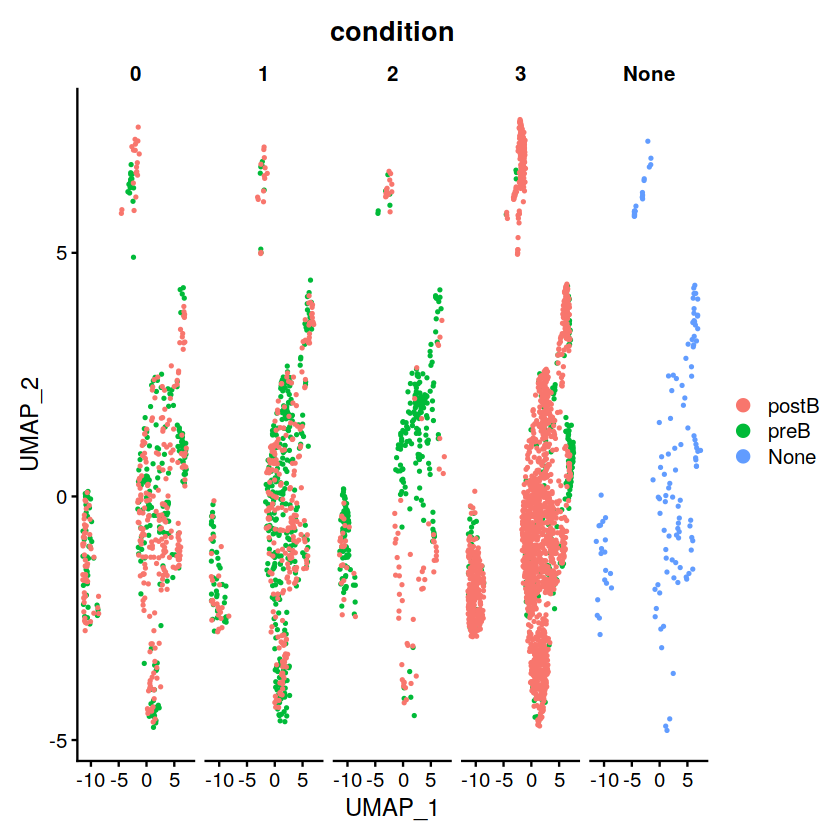

In [26]:
DimPlot(object = se, label = FALSE, split.by=c("donor"), group.by = c('condition'))#, "lineage"))
#ggsave(file.path(outdir, "lineage.conditions.png"))

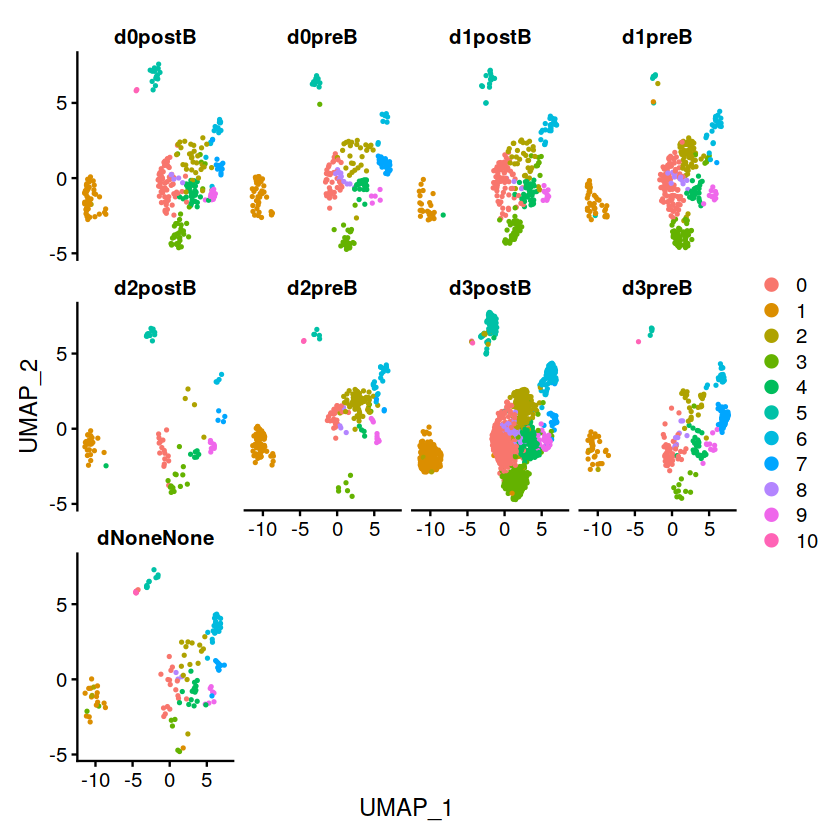

In [24]:
DimPlot(object = se, label = FALSE, split.by=c("donor.cond"),
       ncol=4)#, group.by = c('donor'))
#ggsave(file.path(outdir, "lineage.conditions.png"))

## Get motifs for se

In [11]:
se <- get.pwm(se, genome=genome)

Building motif matrix

Finding motif positions

Creating Motif object

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [12]:
#DefaultAssay(se) <- 'chromvarnames'

# Get JASPAR TF matrix

In [13]:
# # extract position frequency matrices for the motifs
# pwm <- getMatrixSet(
#   x = JASPAR2020,
#   opts = list(species = 9606, all_versions = FALSE)
# )
# fa.file <- Rsamtools::FaFile(genome, index=sprintf("%s.fai", genome)) #,



# DefaultAssay(se) <- "ATAC"

# chrom.assay <- se[["ATAC"]]

# # add motif information
# chrom.assay <- AddMotifs(chrom.assay, genome = fa.file, pfm = pwm)

# se = SetAssayData(se, slot="motifs", Motifs(chrom.assay) )

# se = RunChromVAR(se, genome=fa.file)

# DefaultAssay(se) <- 'chromvar'

In [14]:
# plotDE <- function(integrated, de.results, i, outdir){
#     try
#     {
#     plot1 <- MotifPlot(object = integrated,
#                        motifs = head(rownames(de.results)),
#                        assay = 'ATAC')
#     plot2 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[1],
#       pt.size = 0.1
#     )

#     plot3 <- FeaturePlot(
#       object = integrated,
#       features = rownames(de.results)[2],
#       pt.size = 0.1
#     )
    
#     plot2 | plot3
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.top2.png")))
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.Motifs.png")))
#     ggsave(file.path(outdir,paste0("cluster_",i,".DE.TF.Motifs.pdf")))
#     return(c(plot1, plot2, plot3))
#     }
#     return
# }

# Stimulus specific response
A. Comparing within-cluster condition differences  
B. Comparing within-cluster and within-donor condition differences  
C. Re-compute clusters for each donor and re-run  
D. Clone enrichment in clusters  
E. Overall pre vs post  

In [15]:
# create.ids <- function(se, cols, clust.col="seurat_clusters"){
#     if (length(cols)==0){
#         Idents(se) = clust.id
#     }else{
#         cols = c(cols, clust.col)
#         se$curr.id <- apply(se[[]][ , cols ] , 1 , paste , collapse = "_" )
#         Idents(se) <- "curr.id"
#     }
#     return(se)
# }

# se = create.ids(se, c("donor"))

In [ ]:
clean.de <- function(curr.tf.da, se, n_top_genes, a, b, names.sig = c()){
    DefaultAssay(se) <- "ATAC"
    #curr.tf.da <- read.csv(in_f) %>% arrange(p_val)
    print('curr tf de results')
    print(head(curr.tf.da))
    print('curr.tf rownames')
    print(head(row.names(curr.tf.da)))
    curr.sig <- curr.tf.da %>% dplyr::filter(p_val_adj_BH<0.1)
    if (dim(curr.sig)[1]==0){
        curr.sig <- head(curr.tf.da[order(curr.tf.da$p_val),],3)
    }
    print('curr significant motifs')
    print(dim(curr.sig))

    curr.names <- row.names(curr.sig)
    names.sig <- c(names.sig, curr.names)# head(row.names(curr.tf.da), n_top_genes))
    return(names.sig)
}



de.plots <- function(se.filt, names.sig, curr.outdir, curr.name=""){
    feat <- FeaturePlot(se.filt,  features=names.sig)
    vln <- VlnPlot(se.filt,  features=names.sig, pt.size = 0)
    dot <- DotPlot(se.filt, features = names.sig) + RotatedAxis()

    # split by a vector
    pdf((file.path(curr.outdir, paste0(curr.name, "heatmap.top.pdf")), width=8,height=8)
    heat <- ComplexHeatmap::Heatmap(GetAssayData(se.filt)[names.sig,], 
            name = curr.name,
            column_split = se.filt[[]]["lineage"],
            show_column_names = FALSE, use_raster=TRUE
           )
    ComplexHeatmap::draw(heat)
    dev.off()
    
    ggsave(plot=feat, 
           file=file.path(curr.outdir, paste0(curr.name,"embedFeat.top.png")))
    ggsave(plot=dot, 
           file=file.path(curr.outdir, paste0(curr.name, "dot.top.png")))
    ggsave(plot=vln, 
           file=file.path(curr.outdir, paste0(curr.name, "violin.top.png")))
}

In [93]:




stimout <- function(se, outdir, sample_names, 
                    sample.id = "condition", cols=c()){
    clust.ids <- levels(se$seurat_clusters)
    don.ids <- levels(se$donor)
    
    #cluster.ids <- sort(unique(se$clust.id))
    if (length(cols)==0){
        curr.ids <- as.factor(sample_names)
        Idents(se) <- as.factor(se$sample.id)
        
    }else if(length(cols)==1){
        print('here')
        curr.ids <- levels(se[[]][[cols]])
        Idents(se) <- as.factor(apply(se[[]][ , c(sample.id, cols) ] , 1 , paste , collapse = "_" ))
    }else{
        curr.ids <- levels(as.factor(apply(se[[]][ , cols ] , 1 , paste , collapse = "_" )))
        Idents(se) <- as.factor(apply(se[[]][ , c(sample.id, cols) ] , 1 , paste , collapse = "_" ))
    }
    print(head(Idents(se)))
       
     #<- sort(unique(se$curr.id))
    for (cl in clust.ids){
        for d in don.ids{
            c <- paste0(sample.id, "_", cl, "_" d)
        }
    }
    for (c in curr.ids){
        try({
            print(c)
            if (length(cols)==0){
                id1 <- sample_names[[1]]
                id2 <- sample_names[[2]]
            }else{
                print(c)
                id1 <- paste(sample_names[[1]], c, sep="_")
                id2 <- paste(sample_names[[2]], c, sep="_")
            }
            DefaultAssay(se) <- "chromvarnames"
            se.filt <- subset(se, idents = c(id1,id2))
            curr.clust = se_filt$seurat_clusters[[1]] #strsplit(c,"_")[[2]]
            print(paste0('curr.clust', curr.clust))
            curr.donor = se_filt$donor[[1]] #strsplit(c,"_")[[2]]
            print(paste0('curr.donor', curr.donor))            
            
            curr.clust.outdir <- file.path(outdir, paste0("clust_", curr.clust))
            dir.create(curr.clust.outdir)
            curr.outdir <- file.path(curr.clust.outdir, paste0("donor", curr.clust))
            dir.create(curr.outdir)
            
            response <- FindMarkers(se,
                                    ident.1 = id1,
                                    ident.2 = id2,
                                    verbose = T,
                                    only.pos = FALSE,
                                    mean.fxn = rowMeans,
                                    logfc.threshold = 0,
                                    min.pct = 0.01,
                                    #latent.vars=latent.vars,
                                    fc.name = "avg_diff")
            ncells <- data.frame(table(Idents(se.filt)))
            #ncellsA <- ncells %>% filter(condition==sample_names[[1]])
            #ncellsB <- ncells %>% filter(condition==sample_names[[2]])
            write.csv(ncells, file=file.path(curr.outdir, paste0(c,".counts.csv")), quote=F)
            response <- response %>% arrange(p_val)
            response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))
            print('cleaning de')
            names.sig <- clean.de(response, se, n_top_genes, a=id1, b=id2, names.sig = c())
            #response <- curr.de[[1]]
            #names.sig <- curr.de[[2]]
            print('dim response')
            print(dim(response))
            if (!(dim(response)[1]==0)){
                print('response plots')
                print(head(response, n = 3))
                de.plots(se.filt, names.sig, curr.outdir, curr.name=c)#paste0(cid1,"_", id2)){

                write.csv(response, 
                          file=file.path(curr.outdir, paste(c,sample_names[[1]], sample_names[[2]],"DE.TF.csv",sep="_")), quote=F)
                #plotDE(se, response, c, clust_outdir)

                gally <- GGally::ggpairs(response[,c("p_val", "p_val_adj", "avg_diff", "p_val_adj_BH" )], aes(alpha = 0.4))
                ggsave(plot=gally, file=file.path(curr.outdir, 
                                                  paste(c,sample_names[[1]], 
                                                        sample_names[[2]],".DE.TF.pvalHist.png", sep="_")))

            }
        })

    }
}

## Plot for each folder



## Including donors

In [94]:
stimout(se, cond_outdir, sample_names, sample.id = "condition", cols=c("seurat_clusters", "donor"))

preB_AAACGAAGTCACTCTC-1 preB_AAACGAAGTCCCTAAA-1 preB_AAACGAAGTCTGTGTA-1 
               preB_0_0                preB_3_6                preB_1_2 
preB_AAACTCGCAACTCGTA-1 preB_AAACTCGCAGAACGAC-1 preB_AAACTGCCACACATGT-1 
               preB_2_6                preB_2_5                preB_1_0 
93 Levels: None_None_0 None_None_1 None_None_10 None_None_2 ... preB_3_9
[1] "0_0"
[1] "0_0"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SP1   0.0001688599  0.7425346 0.649 0.388 0.1068883   0.09067453
SOX9  0.0004830873 -0.6391424 0.189 0.537 0.3057943   0.09067453
KLF11 0.0006696921  0.6117558 0.649 0.328 0.4239151   0.09067453
SP3   0.0010399899  0.6373173 0.595 0.373 0.6583136   0.09067453
BACH1 0.0010399899 -0.5768896 0.081 0.030 0.6583136   0.09067453
PAX9  0.0010911705 -0.6589046 0.135 0.343 0.6907110   0.09067453
[1] "curr.tf rownames"
[1] "SP1"   "SOX9"  "KLF11" "SP3"   "BACH1" "PAX9" 
[1] "curr significant motifs"
[1] 10  6
[1

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "0_1"
[1] "0_1"
[1] "cleaning de"
[1] "curr tf de results"
              p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
IRF2   6.626797e-05 1.0555095 0.975 0.923 0.04194762   0.04194762
IRF9   3.652646e-04 1.0423724 0.950 0.942 0.23121248   0.09275012
POU2F1 5.692801e-04 0.8502800 1.000 0.981 0.36035432   0.09275012
POU3F2 5.860987e-04 0.8002714 1.000 0.981 0.37100047   0.09275012
IRF8   1.065757e-03 0.9970724 0.950 0.846 0.67462428   0.13492486
HOXC4  1.652105e-03 0.6249681 0.850 0.731 1.00000000   0.16359171
[1] "curr.tf rownames"
[1] "IRF2"   "IRF9"   "POU2F1" "POU3F2" "IRF8"   "HOXC4" 
[1] "curr significant motifs"
[1] 4 6
[1] "dim response"
[1] 633   6
[1] "response plots"
              p_val avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
IRF2   6.626797e-05 1.055510 0.975 0.923 0.04194762   0.04194762
IRF9   3.652646e-04 1.042372 0.950 0.942 0.23121248   0.09275012
POU2F1 5.692801e-04 0.850280 1.000 0.981 0.36035432   0.09275012


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_10"
[1] "0_10"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_0_10
[1] "0_2"
[1] "0_2"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SP4   0.0002751165 0.6322832 0.750 0.312 0.1741487   0.07093859
KLF14 0.0003870426 0.7798957 0.679 0.312 0.2449980   0.07093859
SP8   0.0004577876 0.5559472 0.786 0.312 0.2897795   0.07093859
SP9   0.0005404553 0.5918292 0.714 0.281 0.3421082   0.07093859
SP3   0.0006030794 0.5980706 0.750 0.344 0.3817493   0.07093859
SP2   0.0006724037 0.5497296 0.714 0.344 0.4256316   0.07093859
[1] "curr.tf rownames"
[1] "SP4"   "KLF14" "SP8"   "SP9"   "SP3"   "SP2"  
[1] "curr significant motifs"
[1] 6 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SP4   0.0002751165 0.6322832 0.750 0.312 0.1741487   0.07093859
KLF14 0.0003870426 0.7798957 0.679 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_3"
[1] "0_3"
[1] "cleaning de"
[1] "curr tf de results"
               p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SPIB    1.029667e-06 -1.3536733 0.038 0.139 0.0006517792 0.0006517792
SPI1    3.205554e-05 -1.0760512 0.038 0.111 0.0202911559 0.0101455780
ETV6    8.001031e-05 -0.8168043 0.154 0.417 0.0506465250 0.0168821750
EHF     1.139558e-04 -0.8964890 0.077 0.222 0.0721340265 0.0180335066
KLF13   3.335625e-04  0.9465438 0.846 0.417 0.2111450377 0.0392438305
ZKSCAN5 3.719794e-04 -0.8120212 0.077 0.361 0.2354629830 0.0392438305
[1] "curr.tf rownames"
[1] "SPIB"    "SPI1"    "ETV6"    "EHF"     "KLF13"   "ZKSCAN5"
[1] "curr significant motifs"
[1] 9 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SPIB 1.029667e-06 -1.3536733 0.038 0.139 0.0006517792 0.0006517792
SPI1 3.205554e-05 -1.0760512 0.038 0.111 0.0202911559 0.0101455780
ETV6 8.001031e-05 -0.8168043 0.154 0.417 0.0506465250 0.0168821750


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_4"
[1] "0_4"
[1] "cleaning de"
[1] "curr tf de results"
            p_val avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF9 1.582807e-08 1.872341 0.913 0.176 1.001917e-05 1.001917e-05
IRF4 2.026425e-07 1.955505 0.870 0.176 1.282727e-04 6.413636e-05
IRF8 2.298989e-06 1.751500 0.870 0.235 1.455260e-03 4.850868e-04
IRF7 5.898297e-06 1.447265 0.826 0.235 3.733622e-03 9.334054e-04
KLF6 4.610094e-05 1.008056 0.783 0.382 2.918189e-02 4.791830e-03
IRF5 5.299022e-05 1.444829 0.783 0.265 3.354281e-02 4.791830e-03
[1] "curr.tf rownames"
[1] "IRF9" "IRF4" "IRF8" "IRF7" "KLF6" "IRF5"
[1] "curr significant motifs"
[1] 29  6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
IRF9 1.582807e-08 1.872341 0.913 0.176 1.001917e-05 1.001917e-05
IRF4 2.026425e-07 1.955505 0.870 0.176 1.282727e-04 6.413636e-05
IRF8 2.298989e-06 1.751500 0.870 0.235 1.455260e-03 4.850868e-04


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_5"
[1] "0_5"
[1] "cleaning de"
[1] "curr tf de results"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
IRF1  0.001109813 1.4106803 1.000 0.812 0.7025119    0.3035836
IRF4  0.001675040 1.3541275 0.933 0.562 1.0000000    0.3035836
IRF2  0.002187960 1.0690146 1.000 0.812 1.0000000    0.3035836
KLF5  0.004159384 0.7465137 0.933 0.750 1.0000000    0.3035836
NFYA  0.004159384 1.0736652 0.933 0.562 1.0000000    0.3035836
HOXB6 0.004159384 0.9348608 0.733 0.250 1.0000000    0.3035836
[1] "curr.tf rownames"
[1] "IRF1"  "IRF4"  "IRF2"  "KLF5"  "NFYA"  "HOXB6"
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 631   6
[1] "response plots"
           p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
IRF1 0.001109813 1.410680 1.000 0.812 0.7025119    0.3035836
IRF4 0.001675040 1.354128 0.933 0.562 1.0000000    0.3035836
IRF2 0.002187960 1.069015 1.000 0.812 1.0000000    0.3035836


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_6"
[1] "0_6"
[1] "cleaning de"
[1] "curr tf de results"
                           p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD2::SMAD3::SMAD4 0.0003400700 -1.373803 0.000 0.647 0.2152643    0.2152643
ELF2                0.0009968393  1.756137 1.000 0.353 0.6309993    0.3154997
ELK3                0.0014988457  1.927114 1.000 0.647 0.9487693    0.3162564
PPARA::RXRA         0.0022252488  1.117596 0.875 0.235 1.0000000    0.3243738
KLF15               0.0026985430  1.111319 1.000 0.294 1.0000000    0.3243738
NFATC2              0.0032621976  1.548551 0.875 0.353 1.0000000    0.3243738
[1] "curr.tf rownames"
[1] "SMAD2::SMAD3::SMAD4" "ELF2"                "ELK3"               
[4] "PPARA::RXRA"         "KLF15"               "NFATC2"             
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                           p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD2::SMAD3::SMAD4 0.0003400700 -1.373803     0 0.647 0.215

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "0_7"
[1] "0_7"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF274 0.002812101  0.8564366 0.730 0.083         1    0.8191078
HOXB3  0.004730753 -0.9707623 0.378 0.833         1    0.8191078
IRF9   0.006298564  0.9866832 0.838 0.333         1    0.8191078
IRF8   0.006757386  0.8833611 0.892 0.500         1    0.8191078
TWIST1 0.007766151  0.7417064 0.568 0.167         1    0.8191078
NFKB2  0.010902036 -0.6959525 0.216 0.417         1    0.8191078
[1] "curr.tf rownames"
[1] "ZNF274" "HOXB3"  "IRF9"   "IRF8"   "TWIST1" "NFKB2" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF274 0.002812101  0.8564366 0.730 0.083         1    0.8191078
HOXB3  0.004730753 -0.9707623 0.378 0.833         1    0.8191078
IRF9   0.006298564  0.9866832 0.838 0.333         1    0.8191078


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "0_8"
[1] "0_8"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
RORC   0.002999752 -1.453732 0.067   0.6         1    0.4505159
CEBPE  0.003970750 -1.488925 0.133   0.8         1    0.4505159
NRF1   0.005219119 -1.279814 0.667   1.0         1    0.4505159
CEBPB  0.005219119 -1.301843 0.067   0.6         1    0.4505159
PHOX2A 0.006811918 -1.355796 0.400   1.0         1    0.4505159
HNF4G  0.006811918 -2.027218 0.067   0.8         1    0.4505159
[1] "curr.tf rownames"
[1] "RORC"   "CEBPE"  "NRF1"   "CEBPB"  "PHOX2A" "HNF4G" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 607   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
RORC  0.002999752 -1.453732 0.067   0.6         1    0.4505159
CEBPE 0.003970750 -1.488925 0.133   0.8         1    0.4505159
NRF1  0.005219119 -1.279814 0.667   1.0         1    0.4505159


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "0_9"
[1] "0_9"
[1] "cleaning de"
[1] "curr tf de results"
                    p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
IRF7          0.004812922  1.455561   1.0 0.348         1    0.9186976
GSC           0.006948023  1.339878   1.0 0.348         1    0.9186976
TFAP2C(var.2) 0.008306756  1.307981   1.0 0.435         1    0.9186976
GSC2          0.009898494  1.260214   1.0 0.391         1    0.9186976
HES1          0.009898494  1.128765   1.0 0.348         1    0.9186976
ZNF528        0.011756497 -1.381160   0.2 0.609         1    0.9186976
[1] "curr.tf rownames"
[1] "IRF7"          "GSC"           "TFAP2C(var.2)" "GSC2"         
[5] "HES1"          "ZNF528"       
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                    p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
IRF7          0.004812922 1.455561     1 0.348         1    0.9186976
GSC           0.006948023 1.339878     1 0.348         1    0.9186976
TFAP2C(var.2)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "1_0"
[1] "1_0"
[1] "cleaning de"
[1] "curr tf de results"
              p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
NFYA   1.904817e-06  0.7536532 0.763 0.512 0.001205749  0.001205749
NFYC   1.526376e-05  0.6869847 0.817 0.512 0.009661961  0.004830981
ARGFX  1.387923e-04 -0.5841376 0.237 0.412 0.087855512  0.029285171
RELA   2.228728e-04 -0.6159135 0.129 0.325 0.141078462  0.031564632
NKX6-2 3.105668e-04 -0.5168992 0.215 0.325 0.196588771  0.031564632
SPIC   3.254593e-04 -0.5232294 0.032 0.050 0.206015736  0.031564632
[1] "curr.tf rownames"
[1] "NFYA"   "NFYC"   "ARGFX"  "RELA"   "NKX6-2" "SPIC"  
[1] "curr significant motifs"
[1] 38  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
NFYA  1.904817e-06  0.7536532 0.763 0.512 0.001205749  0.001205749
NFYC  1.526376e-05  0.6869847 0.817 0.512 0.009661961  0.004830981
ARGFX 1.387923e-04 -0.5841376 0.237 0.412 0.087855512  0.029285171


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "1_1"
[1] "1_1"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF682 0.000730838  0.8057172 0.800  0.44 0.4626204    0.4626204
KLF3   0.002820013  0.6379747 0.775  0.44 1.0000000    0.4694486
SP8    0.003079014  0.5642063 0.775  0.40 1.0000000    0.4694486
SPI1   0.003824114  0.8553510 1.000  1.00 1.0000000    0.4694486
ZNF282 0.004346350  0.6100703 0.850  0.60 1.0000000    0.4694486
SRF    0.005824923 -0.6444424 0.650  0.84 1.0000000    0.4694486
[1] "curr.tf rownames"
[1] "ZNF682" "KLF3"   "SP8"    "SPI1"   "ZNF282" "SRF"   
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ZNF682 0.000730838 0.8057172 0.800  0.44 0.4626204    0.4626204
KLF3   0.002820013 0.6379747 0.775  0.44 1.0000000    0.4694486
SP8    0.003079014 0.5642063 0.775  0.40 1.0000000    0.4694486


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "1_2"
[1] "1_2"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFKB2 5.720803e-05 -0.8447487 0.211 0.657 0.03621269   0.03621269
PAX9  2.509658e-04 -0.7595555 0.239 0.571 0.15886133   0.07612599
RFX3  3.607867e-04 -0.7337082 0.099 0.371 0.22837798   0.07612599
ATF2  1.094971e-03 -0.7243919 0.113 0.371 0.69311690   0.11142413
ETV2  1.121227e-03 -0.7071861 0.183 0.457 0.70973687   0.11142413
HLF   1.121227e-03 -0.6156507 0.268 0.486 0.70973687   0.11142413
[1] "curr.tf rownames"
[1] "NFKB2" "PAX9"  "RFX3"  "ATF2"  "ETV2"  "HLF"  
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFKB2 5.720803e-05 -0.8447487 0.211 0.657 0.03621269   0.03621269
PAX9  2.509658e-04 -0.7595555 0.239 0.571 0.15886133   0.07612599
RFX3  3.607867e-04 -0.7337082 0.099 0.371 0.22837798   0.07612599


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "1_3"
[1] "1_3"
[1] "cleaning de"
[1] "curr tf de results"
                    p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
KLF14        1.281100e-06  0.7890491 0.642 0.200 0.0008109363 0.0006043615
NFYB         1.909515e-06  0.8706811 0.623 0.218 0.0012087230 0.0006043615
IRF3         2.421796e-05 -0.8016013 0.113 0.255 0.0153299688 0.0051099896
POU5F1B      6.152765e-05 -0.7812677 0.113 0.327 0.0389470050 0.0077894010
NFYA         6.152765e-05  0.7947976 0.660 0.364 0.0389470050 0.0077894010
STAT1::STAT2 1.108495e-04 -0.7440030 0.019 0.164 0.0701677132 0.0113638568
[1] "curr.tf rownames"
[1] "KLF14"        "NFYB"         "IRF3"         "POU5F1B"      "NFYA"        
[6] "STAT1::STAT2"
[1] "curr significant motifs"
[1] 82  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
KLF14 1.281100e-06  0.7890491 0.642 0.200 0.0008109363 0.0006043615
NFYB  1.909515e-06  0.8706811 0.623 0.218 0.0012087230 0.000604

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "1_4"
[1] "1_4"
[1] "cleaning de"
[1] "curr tf de results"
                     p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
DLX5           0.002701825 -0.5789881  0.20 0.538         1    0.6793886
CLOCK          0.005442514 -0.7855302  0.16 0.513         1    0.6793886
BHLHE22(var.2) 0.005677567 -0.6255495  0.12 0.462         1    0.6793886
ZNF460         0.010076348  0.4574043  0.60 0.282         1    0.6793886
NFIC(var.2)    0.010906593 -0.5907678  0.24 0.615         1    0.6793886
SNAI3          0.012751479 -0.5861894  0.24 0.513         1    0.6793886
[1] "curr.tf rownames"
[1] "DLX5"           "CLOCK"          "BHLHE22(var.2)" "ZNF460"        
[5] "NFIC(var.2)"    "SNAI3"         
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
                     p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
DLX5           0.002701825 -0.5789881  0.20 0.538         1    0.6793886
CLOCK          0.005442514 -0.7855302  0.16 0.513        

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "1_5"
[1] "1_5"
[1] "cleaning de"
[1] "curr tf de results"
                  p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EN2         0.008922348  1.066006 1.000 0.462         1     0.563892
JUN::JUNB   0.008922348  4.442236 0.857 0.923         1     0.563892
NFIX(var.2) 0.008922348  1.366189 1.000 0.462         1     0.563892
SMAD5       0.011219965  1.201322 0.714 0.385         1     0.563892
PAX6        0.014028631 -1.102217 0.143 0.846         1     0.563892
JDP2        0.014028631  4.421321 1.000 0.923         1     0.563892
[1] "curr.tf rownames"
[1] "EN2"         "JUN::JUNB"   "NFIX(var.2)" "SMAD5"       "PAX6"       
[6] "JDP2"       
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 631   6
[1] "response plots"
                  p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EN2         0.008922348 1.066006 1.000 0.462         1     0.563892
JUN::JUNB   0.008922348 4.442236 0.857 0.923         1     0.563892
NFIX(var.2) 0.008922348 1.366189 1.000 0.462 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "1_6"
[1] "1_6"
[1] "cleaning de"
[1] "curr tf de results"
                p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ETV2      0.005550532  0.7538324 0.826 0.393         1    0.6617698
TBX18     0.005550532  0.8130800 0.957 0.821         1    0.6617698
GATA5     0.005550532  0.7491074 0.739 0.464         1    0.6617698
PRDM1     0.005550532  0.6812883 0.870 0.500         1    0.6617698
CREM      0.005882037 -0.8501021 0.391 0.786         1    0.6617698
MAF::NFE2 0.008273322 -0.7824883 0.478 0.643         1    0.6617698
[1] "curr.tf rownames"
[1] "ETV2"      "TBX18"     "GATA5"     "PRDM1"     "CREM"      "MAF::NFE2"
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
ETV2  0.005550532 0.7538324 0.826 0.393         1    0.6617698
TBX18 0.005550532 0.8130800 0.957 0.821         1    0.6617698
GATA5 0.005550532 0.7491074 0.739 0.464         1    0.6617698


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "1_7"
[1] "1_7"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_1_7
[1] "1_8"
[1] "1_8"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MLX          0.009801427  1.990391 0.571     0         1    0.8163106
MLXIPL       0.009801427  2.148146 0.714     0         1    0.8163106
ARNT2        0.009801427  1.809112 0.714     0         1    0.8163106
TFAP4(var.2) 0.009801427  1.443599 0.214     0         1    0.8163106
BHLHE41      0.014019277  1.919213 0.857     0         1    0.8163106
HOXC11       0.014019277 -1.329364 0.643     1         1    0.8163106
[1] "curr.tf rownames"
[1] "MLX"          "MLXIPL"       "ARNT2"        "TFAP4(var.2)" "BHLHE41"     
[6] "HOXC11"      
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 616   6
[1] "response plots"
             p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
MLX    0.00980

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "1_9"
[1] "1_9"
[1] "cleaning de"
[1] "curr tf de results"
                 p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GATA2      0.004345548 -1.1631140 0.455   1.0         1    0.7964851
KLF14      0.006706276  1.1448448 0.727   0.3         1    0.7964851
ZNF682     0.006706276  1.0036860 0.818   0.3         1    0.7964851
TCFL5      0.006706276 -0.9224892 0.182   0.4         1    0.7964851
SP1        0.008274216  0.9104461 0.636   0.2         1    0.7964851
TAL1::TCF3 0.010162439 -1.2518765 0.273   0.5         1    0.7964851
[1] "curr.tf rownames"
[1] "GATA2"      "KLF14"      "ZNF682"     "TCFL5"      "SP1"       
[6] "TAL1::TCF3"
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 632   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
GATA2  0.004345548 -1.163114 0.455   1.0         1    0.7964851
KLF14  0.006706276  1.144845 0.727   0.3         1    0.7964851
ZNF682 0.006706276  1.003686 0.818   0.3         1    0.7964851

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_0"
[1] "2_0"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP4   3.667491e-07 1.3554964 0.900 0.062 0.0002321522 0.0002321522
SP1   1.353332e-06 1.2800029 0.833 0.125 0.0008566594 0.0004283297
SP8   3.760692e-06 1.1189487 0.700 0.125 0.0023805183 0.0007935061
KLF15 1.377431e-05 0.8993075 0.733 0.188 0.0087191361 0.0021496382
SP3   1.697976e-05 1.0239378 0.733 0.188 0.0107481908 0.0021496382
SP9   2.315072e-05 0.9256053 0.667 0.188 0.0146544028 0.0024424005
[1] "curr.tf rownames"
[1] "SP4"   "SP1"   "SP8"   "KLF15" "SP3"   "SP9"  
[1] "curr significant motifs"
[1] 20  6
[1] "dim response"
[1] 633   6
[1] "response plots"
           p_val avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
SP4 3.667491e-07 1.355496 0.900 0.062 0.0002321522 0.0002321522
SP1 1.353332e-06 1.280003 0.833 0.125 0.0008566594 0.0004283297
SP8 3.760692e-06 1.118949 0.700 0.125 0.0023805183 0.0007935061


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "2_1"
[1] "2_1"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
KLF10 8.453945e-07 1.0166527 0.835 0.348 0.0005351347 0.0005351347
KLF16 3.411912e-06 0.8492905 0.873 0.478 0.0021597404 0.0009075141
KLF6  4.301015e-06 0.8368451 0.911 0.609 0.0027225423 0.0009075141
KLF14 6.062080e-06 0.9521293 0.861 0.391 0.0038372964 0.0009593241
KLF5  1.373543e-05 0.7707881 0.924 0.609 0.0086945243 0.0017389049
KLF2  1.835721e-05 0.7596754 0.924 0.609 0.0116201164 0.0019366861
[1] "curr.tf rownames"
[1] "KLF10" "KLF16" "KLF6"  "KLF14" "KLF5"  "KLF2" 
[1] "curr significant motifs"
[1] 47  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
KLF10 8.453945e-07 1.0166527 0.835 0.348 0.0005351347 0.0005351347
KLF16 3.411912e-06 0.8492905 0.873 0.478 0.0021597404 0.0009075141
KLF6  4.301015e-06 0.8368451 0.911 0.609 0.0027225423 0.0009075141


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "2_10"
[1] "2_10"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_2_10
[1] "2_2"
[1] "2_2"
[1] "cleaning de"
[1] "curr tf de results"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
FOXK1 0.005458582 1.5449698 0.732     0         1     0.594082
KLF5  0.006188296 0.9003268 0.756     0         1     0.594082
ZEB1  0.006188296 1.2489765 0.646     0         1     0.594082
FOXA1 0.007916576 1.4246410 0.756     0         1     0.594082
MEIS3 0.010065215 1.2093221 0.488     0         1     0.594082
TBX6  0.010065215 1.0984237 0.488     0         1     0.594082
[1] "curr.tf rownames"
[1] "FOXK1" "KLF5"  "ZEB1"  "FOXA1" "MEIS3" "TBX6" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
FOXK1 0.005458582 1.5449698 0.732     0         1     0.594082
KLF5  0.006188296 0.9003268 0.756     0    

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_3"
[1] "2_3"
[1] "cleaning de"
[1] "curr tf de results"
             p_val avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
KLF15 0.0001383264 1.148406 0.889 0.071 0.08756061   0.06213056
EGR2  0.0002285647 1.330705 1.000 0.286 0.14468148   0.06213056
KLF5  0.0003720351 1.433809 0.889 0.071 0.23549822   0.06213056
KLF9  0.0004719855 1.210151 0.778 0.071 0.29876680   0.06213056
RUNX3 0.0005965519 1.446872 0.778 0.143 0.37761733   0.06213056
SP8   0.0007511822 1.133920 0.889 0.286 0.47549833   0.06213056
[1] "curr.tf rownames"
[1] "KLF15" "EGR2"  "KLF5"  "KLF9"  "RUNX3" "SP8"  
[1] "curr significant motifs"
[1] 28  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
KLF15 0.0001383264 1.148406 0.889 0.071 0.08756061   0.06213056
EGR2  0.0002285647 1.330705 1.000 0.286 0.14468148   0.06213056
KLF5  0.0003720351 1.433809 0.889 0.071 0.23549822   0.06213056


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "2_4"
[1] "2_4"
[1] "cleaning de"
[1] "curr tf de results"
                 p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
KLF14       0.01073342  1.663911  1.00 0.000         1    0.7510936
MEIS2       0.01073342 -1.327032  0.00 0.857         1    0.7510936
KLF15       0.01073342  1.401402  1.00 0.143         1    0.7510936
SP9         0.01073342  0.926076  0.75 0.000         1    0.7510936
THRB(var.2) 0.01073342 -1.926015  0.00 0.857         1    0.7510936
VEZF1       0.01073342 -1.242184  0.00 0.714         1    0.7510936
[1] "curr.tf rownames"
[1] "KLF14"       "MEIS2"       "KLF15"       "SP9"         "THRB(var.2)"
[6] "VEZF1"      
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 631   6
[1] "response plots"
           p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
KLF14 0.01073342  1.663911     1 0.000         1    0.7510936
MEIS2 0.01073342 -1.327032     0 0.857         1    0.7510936
KLF15 0.01073342  1.401402     1 0.143         1    0.7510936


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_5"
[1] "2_5"
[1] "cleaning de"
[1] "curr tf de results"
            p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SP4   0.001608671 1.443126     1 0.385         1    0.2032557
ESRRB 0.001608671 1.487509     1 1.000         1    0.2032557
SP1   0.001608671 1.596298     1 0.462         1    0.2032557
EHF   0.001608671 3.203480     1 1.000         1    0.2032557
ELF3  0.002244930 2.580012     1 1.000         1    0.2032557
SPI1  0.003104624 2.495526     1 1.000         1    0.2032557
[1] "curr.tf rownames"
[1] "SP4"   "ESRRB" "SP1"   "EHF"   "ELF3"  "SPI1" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 627   6
[1] "response plots"
            p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SP4   0.001608671 1.443126     1 0.385         1    0.2032557
ESRRB 0.001608671 1.487509     1 1.000         1    0.2032557
SP1   0.001608671 1.596298     1 0.462         1    0.2032557


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_6"
[1] "2_6"
[1] "cleaning de"
[1] "curr tf de results"
                p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EGR1      0.003983944 1.047780 0.421  0.00         1    0.5554525
ZBTB7B    0.005136927 2.201750 0.789  0.00         1    0.5554525
ZBTB7C    0.008386548 1.801819 0.737  0.00         1    0.5554525
ZNF460    0.008386548 1.139685 0.842  0.25         1    0.5554525
KLF15     0.010619165 1.235859 0.632  0.00         1    0.5554525
JUN::JUNB 0.016721904 1.654098 0.842  0.25         1    0.5554525
[1] "curr.tf rownames"
[1] "EGR1"      "ZBTB7B"    "ZBTB7C"    "ZNF460"    "KLF15"     "JUN::JUNB"
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
EGR1   0.003983944 1.047780 0.421     0         1    0.5554525
ZBTB7B 0.005136927 2.201750 0.789     0         1    0.5554525
ZBTB7C 0.008386548 1.801819 0.737     0         1    0.5554525


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_7"
[1] "2_7"
[1] "cleaning de"
[1] "curr tf de results"
            p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
INSM1  0.05182993 -0.7976161 0.000  0.25         1      0.97621
SREBF1 0.05182993  1.6287115 1.000  0.25         1      0.97621
HNF1A  0.05182993 -0.9102481 0.000  1.00         1      0.97621
NKX6-2 0.05182993 -0.8555106 0.333  1.00         1      0.97621
ESR1   0.05182993 -1.3194001 0.000  1.00         1      0.97621
ZBED1  0.05182993  1.4015782 1.000  0.25         1      0.97621
[1] "curr.tf rownames"
[1] "INSM1"  "SREBF1" "HNF1A"  "NKX6-2" "ESR1"   "ZBED1" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 621   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
INSM1  0.05182993 -0.7976161     0  0.25         1      0.97621
SREBF1 0.05182993  1.6287115     1  0.25         1      0.97621
HNF1A  0.05182993 -0.9102481     0  1.00         1      0.97621


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "2_8"
[1] "2_8"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: postB_2_8
[1] "2_9"
[1] "2_9"
[1] "cleaning de"
[1] "curr tf de results"
            p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
KLF6 0.0007363404 1.040007 0.917 0.111 0.4661035    0.1406453
SP2  0.0009510827 1.132024 0.667 0.000 0.6020354    0.1406453
KLF5 0.0015643294 1.102662 0.833 0.111 0.9902205    0.1406453
SP8  0.0019920810 1.019111 0.833 0.222 1.0000000    0.1406453
ZIC4 0.0019920810 1.138136 0.750 0.333 1.0000000    0.1406453
SP3  0.0019920810 1.099200 0.750 0.222 1.0000000    0.1406453
[1] "curr.tf rownames"
[1] "KLF6" "SP2"  "KLF5" "SP8"  "ZIC4" "SP3" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
KLF6 0.0007363404 1.040007 0.917 0.111 0.4661035    0.1406453
SP2  0.0009510827 1.132024 0.667 0.000 0.6020354    0.1406453

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_0"
[1] "3_0"
[1] "cleaning de"
[1] "curr tf de results"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
HLF            4.911967e-07 -0.7520339 0.000 0.285 0.0003109275 0.0002412868
CREM           7.623595e-07 -0.7456870 0.065 0.329 0.0004825736 0.0002412868
CREB3L4(var.2) 2.503474e-06 -0.7468268 0.065 0.376 0.0015846989 0.0005242390
CEBPG(var.2)   3.312727e-06 -0.7675390 0.087 0.317 0.0020969559 0.0005242390
JUND(var.2)    1.142053e-05 -0.6431221 0.065 0.277 0.0072291944 0.0012675543
CEBPA          1.346125e-05 -0.6603336 0.087 0.257 0.0085209703 0.0012675543
[1] "curr.tf rownames"
[1] "HLF"            "CREM"           "CREB3L4(var.2)" "CEBPG(var.2)"  
[5] "JUND(var.2)"    "CEBPA"         
[1] "curr significant motifs"
[1] 137   6
[1] "dim response"
[1] 633   6
[1] "response plots"
                      p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
HLF            4.911967e-07 -0.7520339 0.000 0.285 0.0003109275 0.0002412868
CREM           7.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_1"
[1] "3_1"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
REL   7.629089e-10 -1.7385767 0.548 0.969 4.829213e-07 4.829213e-07
RELA  4.357972e-09 -1.6267262 0.774 0.977 2.758596e-06 1.379298e-06
NFYA  4.201168e-06  1.0089754 0.677 0.302 2.659340e-03 8.864465e-04
CREB3 6.574425e-06 -0.9013961 0.129 0.519 4.161611e-03 9.345811e-04
KLF17 7.382157e-06 -0.7360777 0.355 0.756 4.672906e-03 9.345811e-04
FOXG1 1.041448e-05 -0.8978902 0.323 0.691 6.592365e-03 1.098727e-03
[1] "curr.tf rownames"
[1] "REL"   "RELA"  "NFYA"  "CREB3" "KLF17" "FOXG1"
[1] "curr significant motifs"
[1] 141   6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2    p_val_adj p_val_adj_BH
REL  7.629089e-10 -1.738577 0.548 0.969 4.829213e-07 4.829213e-07
RELA 4.357972e-09 -1.626726 0.774 0.977 2.758596e-06 1.379298e-06
NFYA 4.201168e-06  1.008975 0.677 0.302 2.659340e-03 8.864465e-04


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_10"
[1] "3_10"
Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2,  : 
  Cell group 1 has fewer than 3 cells
[1] "3_2"
[1] "3_2"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ETV4  5.622527e-06  0.8949980 0.774 0.386 0.003559059  0.003559059
RFX5  9.319052e-05 -0.7415997 0.129 0.337 0.058989597  0.029494798
RFX2  1.420059e-04 -0.7511163 0.065 0.238 0.089889720  0.029963240
LEF1  3.895056e-04 -0.7051777 0.516 0.733 0.246557068  0.061639267
TCF7  7.683705e-04 -0.6655787 0.387 0.723 0.486378520  0.097275704
FOSL1 1.133129e-03  1.0330841 0.484 0.248 0.717270433  0.101277537
[1] "curr.tf rownames"
[1] "ETV4"  "RFX5"  "RFX2"  "LEF1"  "TCF7"  "FOSL1"
[1] "curr significant motifs"
[1] 5 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
ETV4 5.622527e-06  0.8949980 0.774 0.386 0.003559059  0.003559059
RFX5 9.319052e-05 -0.741

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_3"
[1] "3_3"
[1] "cleaning de"
[1] "curr tf de results"
              p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CEBPB  0.0007599476 -1.0428858 0.000 0.371 0.4810468    0.1943959
PROX1  0.0009874507 -1.0030103 0.154 0.516 0.6250563    0.1943959
CEBPE  0.0012048025 -0.9883117 0.000 0.396 0.7626400    0.1943959
IRF3   0.0013839715  1.0343570 0.538 0.166 0.8760540    0.1943959
ZNF143 0.0017184948  0.8439832 0.769 0.417 1.0000000    0.1943959
HOXB4  0.0019665346 -0.9471761 0.077 0.314 1.0000000    0.1943959
[1] "curr.tf rownames"
[1] "CEBPB"  "PROX1"  "CEBPE"  "IRF3"   "ZNF143" "HOXB4" 
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
CEBPB 0.0007599476 -1.0428858 0.000 0.371 0.4810468    0.1943959
PROX1 0.0009874507 -1.0030103 0.154 0.516 0.6250563    0.1943959
CEBPE 0.0012048025 -0.9883117 0.000 0.396 0.7626400    0.1943959


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_4"
[1] "3_4"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
NFYA  6.950043e-06  0.9948972 0.867 0.526 0.004399377  0.004399377
TCFL5 4.034704e-05 -0.8153821 0.133 0.451 0.025539679  0.007403093
HOXA7 5.447875e-05 -0.8337001 0.100 0.486 0.034485047  0.007403093
HOXB8 5.447875e-05 -0.8337001 0.100 0.486 0.034485047  0.007403093
SPI1  5.847625e-05 -0.7838020 0.000 0.097 0.037015465  0.007403093
SPIC  9.929919e-05 -0.7171261 0.000 0.063 0.062856386  0.009356737
[1] "curr.tf rownames"
[1] "NFYA"  "TCFL5" "HOXA7" "HOXB8" "SPI1"  "SPIC" 
[1] "curr significant motifs"
[1] 44  6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val   avg_diff pct.1 pct.2   p_val_adj p_val_adj_BH
NFYA  6.950043e-06  0.9948972 0.867 0.526 0.004399377  0.004399377
TCFL5 4.034704e-05 -0.8153821 0.133 0.451 0.025539679  0.007403093
HOXA7 5.447875e-05 -0.8337001 0.100 0.486 0.034485047  0.007403093


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_5"
[1] "3_5"
[1] "cleaning de"
[1] "curr tf de results"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SOX8   0.002610864 -1.510320  0.00 0.579         1    0.3402941
ARNT2  0.006321254 -1.521407  0.25 0.737         1    0.3402941
TFE3   0.006515362 -1.585288  0.25 0.713         1    0.3402941
ZNF528 0.006515362 -1.442184  0.25 0.918         1    0.3402941
TFEB   0.006714815 -1.563014  0.25 0.789         1    0.3402941
OSR2   0.007568644 -1.238837  0.25 0.760         1    0.3402941
[1] "curr.tf rownames"
[1] "SOX8"   "ARNT2"  "TFE3"   "ZNF528" "TFEB"   "OSR2"  
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SOX8  0.002610864 -1.510320  0.00 0.579         1    0.3402941
ARNT2 0.006321254 -1.521407  0.25 0.737         1    0.3402941
TFE3  0.006515362 -1.585288  0.25 0.713         1    0.3402941


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"


[1] "3_6"
[1] "3_6"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val   avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFYC        0.0000209065  1.2364574 0.905 0.410 0.01323381  0.008595792
CTCF        0.0000271589 -1.0864152 0.048 0.381 0.01719158  0.008595792
NFYA        0.0001250388  1.1485420 0.762 0.419 0.07914953  0.024688095
GRHL2       0.0001856088 -0.8933583 0.238 0.552 0.11749040  0.024688095
MZF1(var.2) 0.0002006470 -0.9068434 0.286 0.543 0.12700956  0.024688095
ZNF384      0.0002730121 -0.8001351 0.333 0.781 0.17281667  0.024688095
[1] "curr.tf rownames"
[1] "NFYC"        "CTCF"        "NFYA"        "GRHL2"       "MZF1(var.2)"
[6] "ZNF384"     
[1] "curr significant motifs"
[1] 31  6
[1] "dim response"
[1] 633   6
[1] "response plots"
            p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFYC 0.0000209065  1.236457 0.905 0.410 0.01323381  0.008595792
CTCF 0.0000271589 -1.086415 0.048 0.381 0.01719158  0.008595792
NFYA 0.0001250388  1.148542 0.762 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_7"
[1] "3_7"
[1] "cleaning de"
[1] "curr tf de results"
                   p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
CTCF        2.005908e-05 -1.278502 0.074  0.32 0.01269740  0.004080117
FOSL2::JUND 3.181849e-05  1.389972 0.963  0.92 0.02014110  0.004080117
FOSL2::JUNB 3.287146e-05  1.324654 0.963  0.96 0.02080764  0.004080117
FOSL1::JUND 3.507753e-05  1.352684 0.975  0.88 0.02220408  0.004080117
FOSB::JUNB  4.122416e-05  1.332967 0.963  0.96 0.02609489  0.004080117
BATF        4.395822e-05  1.300246 0.975  0.84 0.02782555  0.004080117
[1] "curr.tf rownames"
[1] "CTCF"        "FOSL2::JUND" "FOSL2::JUNB" "FOSL1::JUND" "FOSB::JUNB" 
[6] "BATF"       
[1] "curr significant motifs"
[1] 36  6
[1] "dim response"
[1] 633   6
[1] "response plots"
                   p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
CTCF        2.005908e-05 -1.278502 0.074  0.32 0.01269740  0.004080117
FOSL2::JUND 3.181849e-05  1.389972 0.963  0.92 0.02014110  0.004080117
FOSL2::JUNB 3.287146

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_8"
[1] "3_8"
[1] "cleaning de"
[1] "curr tf de results"
             p_val   avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD5  0.001316156 -1.0930161 0.222 0.696 0.8331270     0.304247
EVX1   0.001429668 -1.2483837 0.000 0.413 0.9049797     0.304247
TCF7L1 0.002144937  1.0418404 1.000 0.761 1.0000000     0.304247
DBP    0.003055347 -0.9876577 0.111 0.630 1.0000000     0.304247
CDX2   0.003429604 -0.8635821 0.000 0.489 1.0000000     0.304247
ETV1   0.003429604  1.2306147 0.667 0.272 1.0000000     0.304247
[1] "curr.tf rownames"
[1] "SMAD5"  "EVX1"   "TCF7L1" "DBP"    "CDX2"   "ETV1"  
[1] "curr significant motifs"
[1] 3 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2 p_val_adj p_val_adj_BH
SMAD5  0.001316156 -1.093016 0.222 0.696 0.8331270     0.304247
EVX1   0.001429668 -1.248384 0.000 0.413 0.9049797     0.304247
TCF7L1 0.002144937  1.041840 1.000 0.761 1.0000000     0.304247


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "3_9"
[1] "3_9"
[1] "cleaning de"
[1] "curr tf de results"
                        p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFYC             6.010454e-05  1.988643   0.8 0.163 0.03804617   0.03060454
NFYA             9.669680e-05  1.963329   0.7 0.116 0.06120908   0.03060454
CREB1            3.429764e-04 -1.267102   0.2 0.791 0.21710403   0.07030968
ATF3             4.442950e-04 -1.275095   0.1 0.605 0.28123871   0.07030968
JDP2(var.2)      7.990062e-04 -1.278177   0.1 0.628 0.50577090   0.09924885
JUN::JUNB(var.2) 9.407474e-04 -1.242841   0.1 0.605 0.59549310   0.09924885
[1] "curr.tf rownames"
[1] "NFYC"             "NFYA"             "CREB1"            "ATF3"            
[5] "JDP2(var.2)"      "JUN::JUNB(var.2)"
[1] "curr significant motifs"
[1] 6 6
[1] "dim response"
[1] 633   6
[1] "response plots"
             p_val  avg_diff pct.1 pct.2  p_val_adj p_val_adj_BH
NFYC  6.010454e-05  1.988643   0.8 0.163 0.03804617   0.03060454
NFYA  9.669680e-05  1.963329   0.7 0.116

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "None_0"
[1] "None_0"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_None_0postB_None_0
[1] "None_1"
[1] "None_1"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_None_1postB_None_1
[1] "None_10"
[1] "None_10"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_None_10postB_None_10
[1] "None_2"
[1] "None_2"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_None_2postB_None_2
[1] "None_3"
[1] "None_3"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: preB_None_3postB_None_3
[1] "None_4"
[1] "None_4"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 


## Not including donors

In [ ]:
stimout(se, cond_outdir, sample_names, sample.id = "condition", cols=c("seurat_clusters"))

In [ ]:
# if ((comps_f=="") | comps_f == "NULL"){
#     stimout(cond_outdir, sample_names)

# }else{
#     comps <- unlist(strsplit(comps_f, ";")[[1]])
#     comps <- lapply(comps, function(x) unlist(strsplit(x, ',')[[1]]))
#     for (i in comps){
#         print(i)
#         curr_sample_names <- i[2:3]
#         curr_cond_outdir <- file.path(cond_outdir, i[1])
#         dir.create(curr_cond_outdir, showWarnings = FALSE)
#         stimout(curr_cond_outdir, curr_sample_names)
#     }
# }


In [45]:
# Idents(se) <- as.factor(apply(se[[]][ , c("condition", cols) ] , 1 , paste , collapse = "_" ))

# head(Idents(se))

# c <- "0_0"
# print(c)
# cols=c("donor", "seurat_clusters")
# if (length(cols)==0){
#     id1 <- sample_names[[1]]
#     id2 <- sample_names[[2]]
# }else{
#     print(c)
#     id1 <- paste(sample_names[[1]], c, sep="_")
#     id2 <- paste(sample_names[[2]], c, sep="_")
# }
# DefaultAssay(se) <- "chromvarnames"
# se.filt <- subset(se, idents %in% c(id1,id2))

In [ ]:
donor.clusters <- function(se.filt, curr.outdir, d, all.names.sig){
    curr.se = subset(se.filt, donor==d)
    plots(curr.se, all.names.sig, curr.outdir)
}

In [ ]:
sessionInfo()